This notebook makes Figure 11 of the paper. 

There's some repeated code compared to other notebooks. 

Options to normalize the histograms or not.

Also makes a version with the mean histograms for Obs & models, but the difference version seems like it is more useful.

In [58]:
from pathlib import Path
import logging
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import ast
import intake
import intake_esm
from intake_esm import DerivedVariableRegistry
import computations as comp
from computations import get_overlapping_time, rm_land, adjust_monthly_time, weighted_binned
import plotting_methods as plm

In [59]:
#
# IDENTIFY VARIABLES NEEDED HERE
#

variables_to_load = ['OMEGA500'] 
other_variables = [] 
remove_land = True 
# Aux. data:
land = xr.load_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC'].squeeze()
land60 = land.sel(lat=slice(-60,60))
if remove_land:
    rmlandstr = "noland"
else:
    rmlandstr = "withland"

# define colors for line plots
colorkey = {"CAM4": "#56B4E9",
           "CAM5": "#0072B2",
           "CAM6": "#E69F00",
           "E3SM": "#D55E00",
           "OBS": "#999999",
           "CALIPSO": "#999999",
           "CERES": "#999999"}

# Catalogs & Derived Variable Registries
rootdir = Path("/Volumes/Drudonna/")
catsfils = {
    "CAM4": rootdir / "cam4_1deg_release_amip" / "catalog" / "catalog_cam4_1deg_release_amip.json",
    "CAM5": rootdir / "cam5_1deg_release_amip" / "catalog" / "catalog_cam5_1deg_release_amip.json",
    "CAM6": rootdir / "f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1" / "catalog" / "catalog_f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.json",
    "E3SM": rootdir / "E3SM-1-0_amip" / "catalog" / "catalog_E3SM-1-0_amip.json",
    "OBS" : rootdir / "catalog_satellite_clouds_monthly.json"
}

# also define the derived variable registry:
dvr_objs = {"CAM4":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM5":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM6":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "E3SM":DerivedVariableRegistry.load("e3sm_derived_variable_registry"),
           "OBS":None}
csv_kw = {"CAM4":None, "CAM5":None, "CAM6":None, "E3SM":None, "OBS":{"converters": {"variable": ast.literal_eval}}}

cats = {c: intake.open_esm_datastore(str(catsfils[c]), registry=dvr_objs[c], read_csv_kwargs=csv_kw[c]) for c in catsfils}


cats_subset = {}
for c in cats:
    if c == 'E3SM':
        cats_subset[c] = cats[c].search(variable=variables_to_load, member_id="r1i1p1f1")
    else:
        try:
            cats_subset[c] =  cats[c].search(variable=variables_to_load)
        except Exception:
            print(f"Sorry -- search failed for {c}")

#
# Loading the datasets
#
dsets = {}
for c in cats_subset:
    dcod = True if c == "OBS" else False
    tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod})
    if len(tmp.keys()) == 1:
        if c == 'OBS':
            dsets[list(tmp.keys())[0]] = tmp[list(tmp.keys())[0]]
        else:
            dsets[c] = tmp[list(tmp.keys())[0]] # call it CAM/E3SM
    elif c == 'E3SM':
        dsets[c] = xr.merge(tmp.values())
    else:
        dsets = {**dsets, **tmp} # adds ISCCP/MISR/MODIS as keys

timeslice = slice("2000-01-01","2020-12-31")

for dsn in dsets:
    if 'time_bnds' in dsets[dsn]:
        bnddim = [d != 'time' for d in dsets[dsn].time_bnds.dims].index(True)
        tmptime = dsets[dsn]['time_bnds'].mean(dim=dsets[dsn].time_bnds.dims[bnddim])
        tmptime.attrs = dsets[dsn]['time'].attrs
        dsets[dsn] = dsets[dsn].assign_coords({"time":tmptime})
        dsets[dsn] = xr.decode_cf(dsets[dsn])
    else:
        print(f"Did not find `time_bnds` in dataset {dsn}")

dsets = {c: dsets[c].sel(time=timeslice).load() for c in dsets}


#
# "Manual" changes to get other data into dicts
#
# -- Add ERA5 omega500 to observation data --
epath = "/Volumes/Drudonna/ERA5/remapped/era5_monthly_w500_1979-2020_unpack.nc" # put onto CAM grid same way as other data & dims renamed
with xr.open_dataset(epath) as eds:
    ew5 = eds['w']*864. 
    ew5.attrs['units'] = 'hPa d**-1'
    ew5.name = "OMEGA500"
    for src in set(cats['OBS'].df['source']):
        if src in dsets:
            select_times = dsets[src]["time"].dt.strftime("%Y-%m")
            ew5_srctime = ew5.sel(time=select_times) 
            assert np.all(ew5_srctime.lat == dsets[src]['lat']), "Lat mismatch"
            assert np.all(ew5_srctime.lon == dsets[src]['lon']), "Lon mismatch"
            ew5_srctime = ew5_srctime.assign_coords({'time':dsets[src]["time"]})
            dsets[src]['OMEGA500'] = ew5_srctime
        else:
            print(f"{src} is not in dsets, so will not add ERA5 OMEGA500 to it.")

if len(other_variables) > 0:
    for ov in other_variables:
        if "relative_entropy" in ov:
            textSearch = "relativeentropy"
            isDistVar = True
            fileVarName = 'relative_entropy'
            plotFileLabel = "Dkl"
        elif "emd" in ov:
            textSearch = "tseries_emd_nanversion"
            isDistVar = True
            fileVarName = 'EMD'
            plotFileLabel = "EMD"
        else:
            raise ValueError("Did not get a valid variable to add")
        if isDistVar:
            product_name = ov.split("_")[0] # format this string like <SATELLITE>_<DISTANCE METRIC>
            print(f"Trying to load {fileVarName} from {product_name}")
            loc = Path("/Users/brianpm/Dropbox/Projects/COSP2")
            for src in dsets:
                print(f"Just to be clear, {src = }")
                possible_matches = sorted(loc.glob(f"{src.lower()}_{product_name}_{textSearch}.nc"))
                if not possible_matches:
                    print(f"no matches for {src = }")
                else:
                    sel = possible_matches[-1]
                    print(f"SELECTING FILE: {sel}")
                    with xr.open_dataset(sel) as selds:
                        assert fileVarName in selds, f'Problem: did not find {fileVarName} in {sel}'
                        print(f"At load, number of non-missing values: {np.count_nonzero(~np.isnan(selds[fileVarName]))}")
                        compare_lat = np.all(dsets[src]['OMEGA500']['lat'].values == selds['lat'].values)
                        if not compare_lat:
                            lat_disagree = np.max(np.absolute(dsets[src]['OMEGA500']['lat'].values - selds['lat'].values))
                            print(f"LAT DISCREPANCY UP TO: {lat_disagree}")
                            if lat_disagree <= 1e-6:
                                print(f"Will reassign {fileVarName} latitude to OMEGA500 version")
                                selds = selds.assign_coords({"lat":dsets[src]['OMEGA500']['lat']})
                        compare_lon = np.all(dsets[src]['OMEGA500']['lon'].values == selds['lon'].values)
                        if not compare_lon:
                            lon_disagree = np.max(np.absolute(dsets[src]['OMEGA500']['lon'].values - selds['lon'].values))
                            print(f"LON DISCREPANCY UP TO: {lon_disagree}")
                            if lon_disagree <= 1e-6:
                                print(f"Will reassign {fileVarName} longitude to OMEGA500 version")
                                selds = selds.assign_coords({"lon":dsets[src]['OMEGA500']['lon']})
                        print(f"At the end, number of non-missing values: {np.count_nonzero(~np.isnan(selds[fileVarName]))}")
                        # in case of subsetting, check for overlapping time:
                        dstmp, selds = get_overlapping_time(dsets[src], selds)
                        selds = selds.assign_coords({"time":dstmp.time})
                        dsets[src] = dstmp
                        dsets[src][fileVarName] = selds[fileVarName]


# At this point, I want to make sure that OMEGA500 is in hPa/day and clcalipso is in PERCENT for all datasets
for d in dsets:
    if 'clcalipso' in dsets[d]:
        if dsets[d]['clcalipso'].max() < 2:
            dsets[d]['clcalipso'] *= 100.0
            dsets[d]['clcalipso'].attrs['units'] = 'percent'
            print(f"Adjusted clcalipso for {d}")
    if 'OMEGA500' in dsets[d]:
        if dsets[d]['OMEGA500'].max() < 10:
            print(f"inferring that OMEGA500 is in Pa/s ---> units says: {dsets[d]['OMEGA500'].attrs['units']}")
            if 'hPa' not in dsets[d]['OMEGA500'].attrs['units']:
                print("double checked and `hPa` not in units, so will transform")
                dsets[d]['OMEGA500'] *= 864.0
                dsets[d]['OMEGA500'].attrs['units'] = 'hPa d**-1'

## ALSO, for some reason altitude is the dimension name in CALIPSO, but not a coordinate variable, so fix that here
if "CALIPSO" in dsets:
    if 'altitude' not in dsets["CALIPSO"].coords:
        with xr.open_dataset("/Volumes/Drudonna/CALIPSO/GOCCP/3Ddata/remapped/fv09/3D_CloudFraction330m_200606_avg_CFMIP2_sat_3.1.2.nc") as exfile:
            dsets["CALIPSO"] = dsets["CALIPSO"].assign_coords({'altitude':exfile['alt_mid']})


/var/folders/3y/4dzlw6yj5bj8ds39vpvyg92m0000gp/T/ipykernel_57404/3756056565.py:62: UserWarning: There are no datasets to load! Returning an empty dictionary.
  tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod})


CERES is not in dsets, so will not add ERA5 OMEGA500 to it.
CALIPSO is not in dsets, so will not add ERA5 OMEGA500 to it.
ISCCP is not in dsets, so will not add ERA5 OMEGA500 to it.
MODIS is not in dsets, so will not add ERA5 OMEGA500 to it.
MISR is not in dsets, so will not add ERA5 OMEGA500 to it.
inferring that OMEGA500 is in Pa/s ---> units says: Pa/s
double checked and `hPa` not in units, so will transform
inferring that OMEGA500 is in Pa/s ---> units says: Pa/s
double checked and `hPa` not in units, so will transform
inferring that OMEGA500 is in Pa/s ---> units says: Pa/s
double checked and `hPa` not in units, so will transform
inferring that OMEGA500 is in Pa/s ---> units says: Pa s-1
double checked and `hPa` not in units, so will transform


In [60]:
# Construct the "OBS" entry
isccp = comp.Satellite("ISCCP") # gets the remapped version
ods = isccp.load_monthly()
ods = ods.sel(time=slice("2000-01-01","2016-12-31"))
clisccp = ods['n_pctaudist']

era5wapds = xr.open_dataset("/Volumes/Drudonna/ERA5/remapped/era5_monthly_w500_1979-2020_unpack.nc")
era5_w5 = era5wapds['w'].sel(time=slice('2000-01-01','2016-12-31'))*864.0
era5_w5.attrs['units'] = 'hPa d**-1'

clisccp = clisccp.assign_coords({'time':era5_w5.time}) # have to make sure time coord matches
clisccp.name = 'clisccp'
era5_w5.name = 'OMEGA500'

dsets['OBS'] = xr.merge([clisccp, era5_w5])


# E3SM reuses "plev" in the files for both OMEGA and clisccp, which breaks the merging
for m in ['CAM4', 'CAM5', 'CAM6', 'E3SM']:
    model_isccp = comp.Model(m, "ISCCP", 'daterange')
    model_clisccp = model_isccp.load_data()
    model_clisccp = model_clisccp.sel(time=slice("2001-01-01", None)).compute()
    if m == "E3SM":
        model_clisccp = model_clisccp.rename({'plev':'cosp_prs'})
    dsets[m]['clisccp'] = model_clisccp[model_isccp.data_var_name]





In [61]:
if remove_land:
    landfrac = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC'].squeeze()
    for d in dsets:
        dsets[d] = comp.rm_land(dsets[d], landfrac)

[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.


In [70]:
do_normalize = False

dims = {
    "CAM4": {"p": "cosp_prs", "tau": "cosp_tau"},
    "CAM5": {"p": "cosp_prs", "tau": "cosp_tau"},
    "CAM6": {"p": "cosp_prs", "tau": "cosp_tau"},
    "E3SM": {"p": "cosp_prs", "tau": "tau"},
    "OBS": {"p":"levpc", "tau":"levtau"}
}

ws = {}
s = {}
convective = {}
p75 = {}
tropics = slice(-30, 30)
for d in dsets:
    q = np.nanquantile(
        dsets[d]["OMEGA500"].sel(lat=tropics).values, [0.5, 0.66, 0.75]
    )  # quantiles of OMEGA500 over tropical ocean
    p75[d] = q[2]
    print(f"{d}: median: {q[0]}, 66th: {q[1]}, 75th: {q[2]}")
    cname = "FISCCP1_COSP" if "FISCCP1_COSP" in dsets[d] else "clisccp"
    sample = (
        (xr.where(dsets[d]["OMEGA500"] > q[2], dsets[d][cname], np.nan))
        .sel(lat=tropics)
        .sel({dims[d]["tau"]: slice(0.3, None)})
    )  # ISCCP data when subsidence is strong
    if do_normalize:
        sample = sample / sample.sum(
            dim=(dims[d]["p"], dims[d]["tau"])
        )  # normalize so sum of histograms is 1.0
    print(
        f"Number of values in strong subsidence: {np.count_nonzero(~np.isnan(sample))}"
    )
    s[d] = (
        sample.weighted(sample.time.dt.daysinmonth)
        .mean(dim="time")
        .weighted(np.cos(np.radians(sample.lat)))
        .mean(dim=("lat", "lon"))
    ).compute()
    sample2 = (
        xr.where(
            (dsets[d]["OMEGA500"] > 0) & (dsets[d]["OMEGA500"] < q[2]),
            dsets[d][cname],
            np.nan,
        )
    ).sel(
        {"lat":tropics, dims[d]["tau"]: slice(0.3,None)}        
    )  # tropical ocean Weak Subsidence
    if do_normalize:
        sample2 = sample2 / sample2.sum(
            dim=(dims[d]["p"], dims[d]["tau"])
        )  # normalize so sum of histograms is 1.0
    ws[d] = (
        sample2.weighted(sample2.time.dt.daysinmonth)
        .mean(dim="time")
        .weighted(np.cos(np.radians(sample2.lat)))
        .mean(dim=("lat", "lon"))
    ).compute()
    print(
        f"Number of values in weak subsidence: {np.count_nonzero(~np.isnan(sample2))}"
    )
    sample3 = (xr.where((dsets[d]["OMEGA500"] < 0), dsets[d][cname], np.nan)).sel(
        {"lat":tropics, dims[d]["tau"]: slice(0.3,None)}
    )  # tropical ocean convective
    if do_normalize:
        sample3 = sample3 / sample3.sum(
            dim=(dims[d]["p"], dims[d]["tau"])
        )  # normalize so sum of histograms is 1.0
    convective[d] = (
        sample3.weighted(sample3.time.dt.daysinmonth)
        .mean(dim="time")
        .weighted(np.cos(np.radians(sample3.lat)))
        .mean(dim=("lat", "lon"))
    ).compute()
    print(f"Number of values in convective: {np.count_nonzero(~np.isnan(sample3))}")

CAM4: median: 11.905020713806152, 66th: 20.737529754638672, 75th: 24.176340579986572
Number of values in strong subsidence: 16448082
Number of values in weak subsidence: 24721410
Number of values in convective: 24642828
CAM5: median: 11.571540355682373, 66th: 20.551753959655763, 75th: 23.983433723449707
Number of values in strong subsidence: 16453080
Number of values in weak subsidence: 24118164
Number of values in convective: 25241076
CAM6: median: 13.58326244354248, 66th: 21.10629596710205, 75th: 24.44406032562256
Number of values in strong subsidence: 22943634
Number of values in weak subsidence: 37350096
Number of values in convective: 31843518
E3SM: median: 12.112529277801514, 66th: 21.333929824829102, 75th: 25.346232414245605
Number of values in strong subsidence: 22987440
Number of values in weak subsidence: 34926864
Number of values in convective: 34222944
OBS: median: 13.445577935530121, 66th: 21.080824540430125, 75th: 24.783075840739663
Number of values in strong subsidence: 

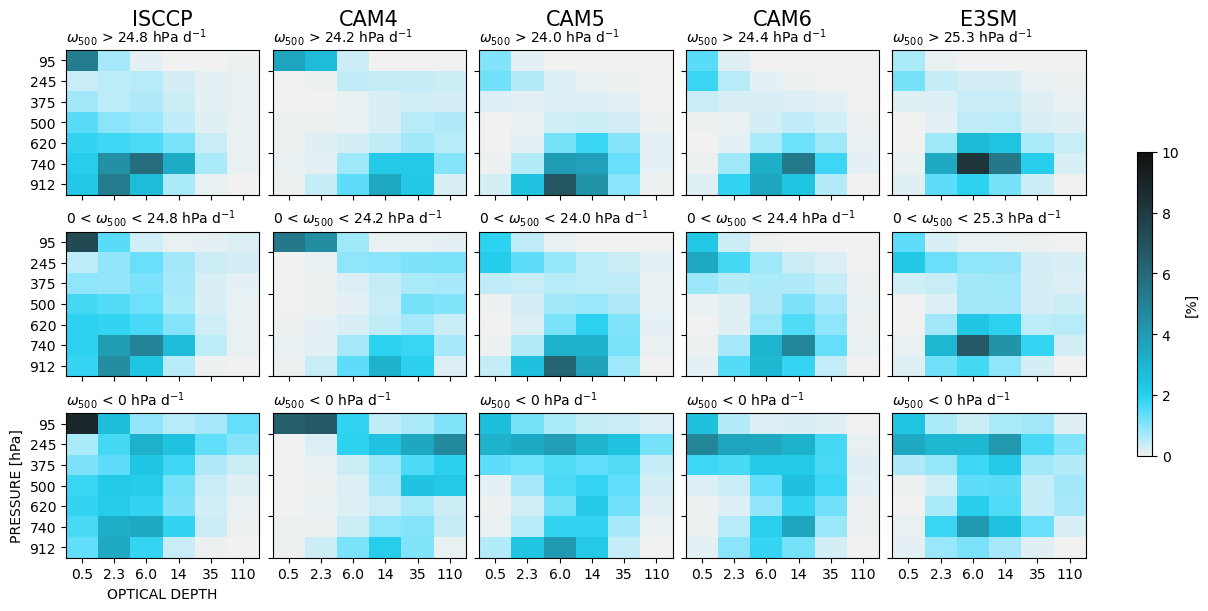

In [71]:
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter
import colorcet as cc

xtcklbls = [str(int(np.rint(tck))) if tck > 10 else str(tck) for tck in s['OBS']['levtau'].values ]
ytcklbls = [str(int(np.rint(tck))) for tck in s['OBS']['levpc'].values ]

if do_normalize:
    colornorm = mpl.colors.Normalize(vmin=0, vmax=0.1)
    donormstring = "norm"
else:
    colornorm = mpl.colors.Normalize(vmin=0, vmax=10)
    donormstring = "nonnorm"
    
colormap = cc.cm.CET_CBTL3_r # cc.cm.CET_CBTL2_r # "Greys"

fig, ax = plt.subplots(figsize=(12,6), nrows=3, ncols=5, constrained_layout=True, sharex=True)


img = ax[0,0].pcolormesh(s['OBS'].transpose(), norm=colornorm, cmap=colormap)
ax[0,0].set_yticks(np.linspace(0.5, 6.5, 7))
# ax[0].set_yticklabels(s['OBS']['levpc'].values)
ax[0,0].set_yticklabels(ytcklbls)
ax[0,0].invert_yaxis()
ax[0,0].set_xticks(np.linspace(0.5, 5.5, 6))


# ax[0].set_xticklabels(s['OBS']['levtau'].values)
ax[0,0].set_xticklabels(xtcklbls)
ax[0,0].set_title("$\omega_{{500}}$ > {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75['OBS'],1)), loc='left', fontsize=10)

# ax[0,0].set_ylabel("PRESSURE [hPa]")
# ax[0,0].set_xlabel("OPTICAL DEPTH")

fig.colorbar(img, ax=ax.ravel(), label='[%]', shrink=0.6)

ax[1,0].pcolormesh(ws['OBS'].transpose(), norm=colornorm, cmap=colormap)
ax[1,0].set_yticks(np.linspace(0.5, 6.5, 7))
# ax[0].set_yticklabels(s['OBS']['levpc'].values)
ax[1,0].set_yticklabels(ytcklbls)
ax[1,0].invert_yaxis()
ax[1,0].set_xticks(np.linspace(0.5, 5.5, 6))
ax[1,0].set_xticklabels(xtcklbls)
ax[1,0].set_title("0 < $\omega_{{500}}$ < {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75['OBS'],1)), loc='left', fontsize=10)
# ax[1,0].set_ylabel("PRESSURE [hPa]")
# ax[1,0].set_xlabel("OPTICAL DEPTH")

ax[2,0].pcolormesh(convective['OBS'].transpose(), norm=colornorm, cmap=colormap)
ax[2,0].set_yticks(np.linspace(0.5, 6.5, 7))
ax[2,0].set_yticklabels(ytcklbls)
ax[2,0].invert_yaxis()
ax[2,0].set_xticks(np.linspace(0.5, 5.5, 6))
ax[2,0].set_xticklabels(xtcklbls)
ax[2,0].set_title("$\omega_{{500}}$ < 0 hPa d$^{{-1}}$", loc='left', fontsize=10)
ax[2,0].set_ylabel("PRESSURE [hPa]")
ax[2,0].set_xlabel("OPTICAL DEPTH")

for i, m in enumerate(['CAM4', 'CAM5', 'CAM6', 'E3SM'], start=1):
    pdata = s[m].transpose(dims[m]["p"], dims[m]["tau"]).sel({dims[m]['tau']:slice(0.3,None)})
    pvals = pdata[dims[m]['p']].values
    if np.min(pvals) > 2000:
        pvals *= 0.01 # Pa -> hPa
    tvals = pdata[dims[m]['tau']].values
    img = ax[0,i].pcolormesh(pdata, norm=colornorm, cmap=colormap)
    # ax[0,i].set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
    # ax[0,i].set_yticklabels(pvals)
    if pvals[1] > pvals[0]:
        print("invert")
        ax[0,i].invert_yaxis()
    if len(tvals) == 6:
        ax[0,i].set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
    elif len(tvals) == 7:
        ax[0,i].set_xticks(np.linspace(1.5, len(tvals)-0.5, len(tvals)-1))
    ax[0,i].set_xticklabels(xtcklbls)
    ax[0,i].set_yticklabels([])
    ax[0,i].set_title("$\omega_{{500}}$ > {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75[m],1)), loc='left', fontsize=10)

    wsdata = ws[m].transpose(dims[m]["p"], dims[m]["tau"]).sel({dims[m]['tau']:slice(0.3,None)})
    pvals = wsdata[dims[m]['p']].values
    if np.min(pvals) > 2000:
        pvals *= 0.01 # Pa -> hPa
    tvals = wsdata[dims[m]['tau']].values
    ax[1,i].pcolormesh(wsdata, norm=colornorm, cmap=colormap)
    # ax[1,i].set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
    # ax[1,i].set_yticklabels(pvals)
    if pvals[1] > pvals[0]:
        print("invert")
        ax[1,i].invert_yaxis()
    if len(tvals) == 6:
        ax[1,i].set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
    elif len(tvals) == 7:
        ax[1,i].set_xticks(np.linspace(1.5, len(tvals)-0.5, len(tvals)-1))
    ax[1,i].set_xticklabels(xtcklbls)
    ax[1,i].set_yticklabels([])
    ax[1,i].set_title("0 < $\omega_{{500}}$ < {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75[m],1)), loc='left', fontsize=10)

    cvdata = convective[m].transpose(dims[m]["p"], dims[m]["tau"]).sel({dims[m]['tau']:slice(0.3,None)})
    pvals = cvdata[dims[m]['p']].values
    if np.min(pvals) > 2000:
        pvals *= 0.01 # Pa -> hPa
    tvals = cvdata[dims[m]['tau']].values
    ax[2,i].pcolormesh(cvdata, norm=colornorm, cmap=colormap)
    # ax[1,i].set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
    # ax[1,i].set_yticklabels(pvals)
    if pvals[1] > pvals[0]:
        print("invert")
        ax[2,i].invert_yaxis()
    if len(tvals) == 6:
        ax[2,i].set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
    elif len(tvals) == 7:
        ax[2,i].set_xticks(np.linspace(1.5, len(tvals)-0.5, len(tvals)-1))
    ax[2,i].set_xticklabels(xtcklbls)
    ax[2,i].set_yticklabels([])
    ax[2,i].set_title("$\omega_{{500}}$ < 0 hPa d$^{{-1}}$", loc='left', fontsize=10)

for a, col in zip(ax[0,:], ['ISCCP', 'CAM4', 'CAM5', 'CAM6', 'E3SM']):
    a.annotate(col, (0.5, 1), xytext=(0, 15), ha='center', va='bottom',
                size=15, xycoords='axes fraction', textcoords='offset points')


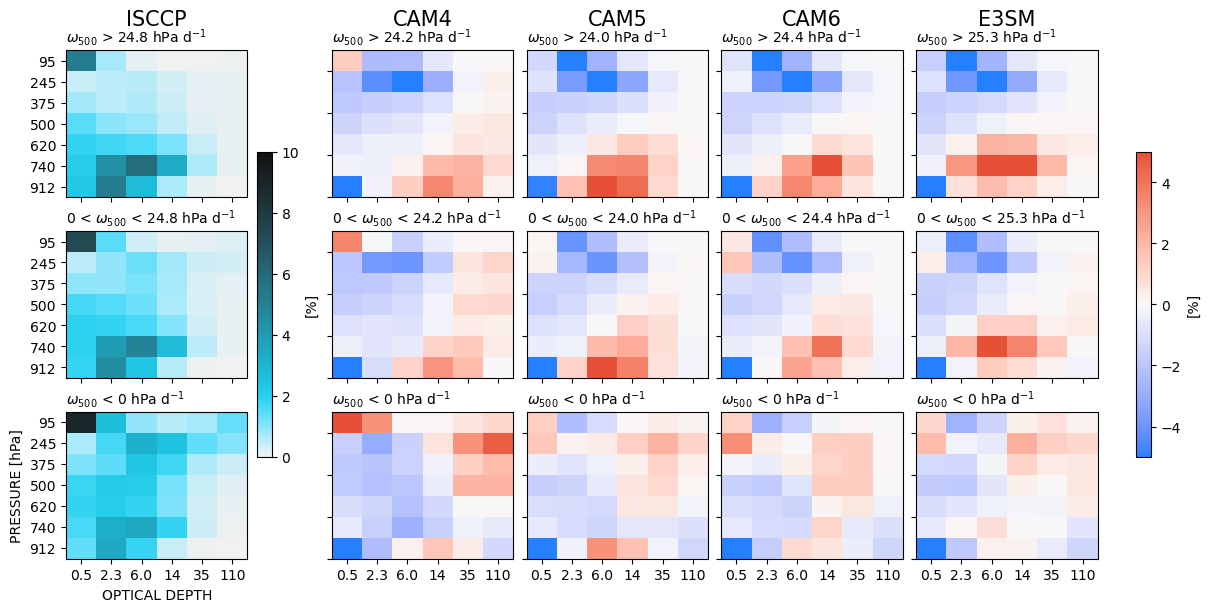

In [72]:
#
# Same thing, but here show the model minus observation
#

if do_normalize:
    colornorm = mpl.colors.Normalize(vmin=0, vmax=0.1)
    diffcolornorm = mpl.colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)
    cblabel = "[fraction]"
    donormstring = "norm"
else:
    colornorm = mpl.colors.Normalize(vmin=0, vmax=10)
    diffcolornorm = mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
    cblabel = "[%]"
    donormstring = "nonnorm"

diffcolormap = cc.cm.CET_D9 # cc.cm.CET_CBTL2_r # "Greys"

fig, ax = plt.subplots(figsize=(12,6), nrows=3, ncols=5, constrained_layout=True, sharex=True)


img = ax[0,0].pcolormesh(s['OBS'].transpose(), norm=colornorm, cmap=colormap)
ax[0,0].set_yticks(np.linspace(0.5, 6.5, 7))
# ax[0].set_yticklabels(s['OBS']['levpc'].values)
ax[0,0].set_yticklabels(ytcklbls)
ax[0,0].invert_yaxis()
ax[0,0].set_xticks(np.linspace(0.5, 5.5, 6))


# ax[0].set_xticklabels(s['OBS']['levtau'].values)
ax[0,0].set_xticklabels(xtcklbls)
ax[0,0].set_title("$\omega_{{500}}$ > {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75['OBS'],1)), loc='left', fontsize=10)

# ax[0,0].set_ylabel("PRESSURE [hPa]")
# ax[0,0].set_xlabel("OPTICAL DEPTH")


ax[1,0].pcolormesh(ws['OBS'].transpose(), norm=colornorm, cmap=colormap)
ax[1,0].set_yticks(np.linspace(0.5, 6.5, 7))
# ax[0].set_yticklabels(s['OBS']['levpc'].values)
ax[1,0].set_yticklabels(ytcklbls)
ax[1,0].invert_yaxis()
ax[1,0].set_xticks(np.linspace(0.5, 5.5, 6))
ax[1,0].set_xticklabels(xtcklbls)
ax[1,0].set_title("0 < $\omega_{{500}}$ < {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75['OBS'],1)), loc='left', fontsize=10)
# ax[1,0].set_ylabel("PRESSURE [hPa]")
# ax[1,0].set_xlabel("OPTICAL DEPTH")

ax[2,0].pcolormesh(convective['OBS'].transpose(), norm=colornorm, cmap=colormap)
ax[2,0].set_yticks(np.linspace(0.5, 6.5, 7))
ax[2,0].set_yticklabels(ytcklbls)
ax[2,0].invert_yaxis()
ax[2,0].set_xticks(np.linspace(0.5, 5.5, 6))
ax[2,0].set_xticklabels(xtcklbls)
ax[2,0].set_title("$\omega_{{500}}$ < 0 hPa d$^{{-1}}$", loc='left', fontsize=10)
ax[2,0].set_ylabel("PRESSURE [hPa]")
ax[2,0].set_xlabel("OPTICAL DEPTH")

fig.colorbar(img, ax=ax[:,0].ravel(), label=cblabel, shrink=0.6)

for i, m in enumerate(['CAM4', 'CAM5', 'CAM6', 'E3SM'], start=1):
    pdata = s[m].transpose(dims[m]["p"], dims[m]["tau"]).sel({dims[m]['tau']:slice(0.3,None)})
    pvals = pdata[dims[m]['p']].values
    if np.min(pvals) > 2000:
        pvals *= 0.01 # Pa -> hPa
    tvals = pdata[dims[m]['tau']].values

    diffdata = pdata - s['OBS'].transpose().values
    img = ax[0,i].pcolormesh(diffdata, norm=diffcolornorm, cmap=diffcolormap)

    # ax[0,i].set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
    # ax[0,i].set_yticklabels(pvals)
    if pvals[1] > pvals[0]:
        print("invert")
        ax[0,i].invert_yaxis()
    if len(tvals) == 6:
        ax[0,i].set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
    elif len(tvals) == 7:
        ax[0,i].set_xticks(np.linspace(1.5, len(tvals)-0.5, len(tvals)-1))
    ax[0,i].set_xticklabels(xtcklbls)
    ax[0,i].set_yticklabels([])
    ax[0,i].set_title("$\omega_{{500}}$ > {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75[m],1)), loc='left', fontsize=10)

    wsdata = ws[m].transpose(dims[m]["p"], dims[m]["tau"]).sel({dims[m]['tau']:slice(0.3,None)})
    pvals = wsdata[dims[m]['p']].values
    if np.min(pvals) > 2000:
        pvals *= 0.01 # Pa -> hPa
    tvals = wsdata[dims[m]['tau']].values
    diffdata = wsdata - ws['OBS'].transpose().values
    ax[1,i].pcolormesh(diffdata, norm=diffcolornorm, cmap=diffcolormap)
    # ax[1,i].set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
    # ax[1,i].set_yticklabels(pvals)
    if pvals[1] > pvals[0]:
        print("invert")
        ax[1,i].invert_yaxis()
    if len(tvals) == 6:
        ax[1,i].set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
    elif len(tvals) == 7:
        ax[1,i].set_xticks(np.linspace(1.5, len(tvals)-0.5, len(tvals)-1))
    ax[1,i].set_xticklabels(xtcklbls)
    ax[1,i].set_yticklabels([])
    ax[1,i].set_title("0 < $\omega_{{500}}$ < {val:.1f} hPa d$^{{-1}}$".format(val=np.round(p75[m],1)), loc='left', fontsize=10)

    cvdata = convective[m].transpose(dims[m]["p"], dims[m]["tau"]).sel({dims[m]['tau']:slice(0.3,None)})
    pvals = cvdata[dims[m]['p']].values
    if np.min(pvals) > 2000:
        pvals *= 0.01 # Pa -> hPa
    tvals = cvdata[dims[m]['tau']].values

    diffdata = cvdata - convective['OBS'].transpose().values
    dimg = ax[2,i].pcolormesh(diffdata, norm=diffcolornorm, cmap=diffcolormap)
    # ax[1,i].set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
    # ax[1,i].set_yticklabels(pvals)
    if pvals[1] > pvals[0]:
        print("invert")
        ax[2,i].invert_yaxis()
    if len(tvals) == 6:
        ax[2,i].set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
    elif len(tvals) == 7:
        ax[2,i].set_xticks(np.linspace(1.5, len(tvals)-0.5, len(tvals)-1))
    ax[2,i].set_xticklabels(xtcklbls)
    ax[2,i].set_yticklabels([])
    ax[2,i].set_title("$\omega_{{500}}$ < 0 hPa d$^{{-1}}$", loc='left', fontsize=10)


cbdiff = fig.colorbar(dimg, ax=ax[:,1:].ravel(), shrink=0.6, label=cblabel)

for a, col in zip(ax[0,:], ['ISCCP', 'CAM4', 'CAM5', 'CAM6', 'E3SM']):
    a.annotate(col, (0.5, 1), xytext=(0, 15), ha='center', va='bottom',
                size=15, xycoords='axes fraction', textcoords='offset points')

fig.savefig(f"/Users/brianpm/Dropbox/Projects/COSP2/combined_composite_histograms_tropocn_{donormstring}_REVISED.pdf", bbox_inches='tight', dpi=300)

tvals = array([  0.8 ,   2.45,   6.5 ,  16.2 ,  41.5 , 100.  ])
pvals = array([900., 740., 620., 500., 375., 245.,  90.])


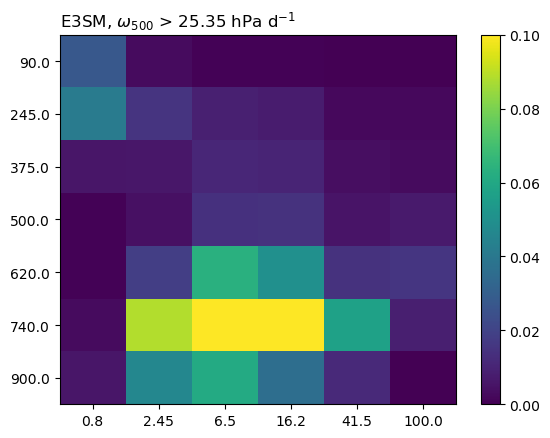

In [65]:
#
# Draft histogram plot
#

fig, ax = plt.subplots()

m = 'E3SM'
pvals = s[m][dims[m]['p']].values
if np.min(pvals) > 2000:
    pvals *= 0.01 # Pa -> hPa
tvals = s[m][dims[m]['tau']].values
img = ax.pcolormesh(s[m].transpose(dims[m]["p"], dims[m]["tau"]), norm=colornorm)
ax.set_yticks(np.linspace(0.5, len(pvals)-0.5, len(pvals)))
ax.set_yticklabels(pvals)
if pvals[1] > pvals[0]:
    print("invert")
    ax.invert_yaxis()
print(f"{tvals = }")
print(f"{pvals = }")
ax.set_xticks(np.linspace(0.5, len(tvals)-0.5, len(tvals)))
ax.set_xticklabels(tvals)
ax.set_title("{name}, $\omega_{{500}}$ > {val:.2f} hPa d$^{{-1}}$".format(name=m, val=p75[m]), loc='left')
fig.colorbar(img)
